# Introduction to Recurrent Neural Networks (RNNs)
**Authors:** Dr. Rishikesh Yadav / Vedant Vibhor

This notebook introduces Recurrent Neural Networks (RNNs) for time series forecasting using the [UCI Air Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Air+Quality). We predict hourly Carbon Monoxide (CO) concentrations (`CO(GT)`) based on 24 hours of past sensor data. **Learning objectives**:
- Understand RNNs and their 'memory' for sequential data
- Preprocess real-world time series data (e.g., handle missing values, create sequences)
- Build, train, and evaluate a simple RNN model
- Visualize predictions and interpret results

**Why RNNs?** Unlike feedforward neural networks, RNNs maintain a hidden state that captures information from previous time steps, making them ideal for sequential data like time series, text, or speech. In this lab, we use a simple RNN to forecast air pollution, demonstrating how past measurements influence future predictions.

## 1. Import Libraries

We use `pandas` for data loading, `numpy` for array operations, `tensorflow` for RNN modeling, `sklearn` for scaling, and `matplotlib` for visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Preprocess the UCI Air Quality Dataset

The dataset contains hourly sensor measurements from an Italian city (March 2004–February 2005). We focus on `CO(GT)` (CO concentration in mg/m³), `PT08.S1(CO)` (CO sensor response), `T` (temperature), and `RH` (relative humidity). Missing values are coded as `-200`.

**Steps**:
- Download and extract the dataset
- Handle missing values with forward fill
- Create a datetime index
- Normalize features to [0, 1]

In [ ]:
# UCI Air Quality dataset URL (semicolon-separated, decimal comma)
df = pd.read_csv('../data/AirQualityUCI.csv', sep=';', decimal=',',na_values=-200)

# Drop empty columns and rows with all NaNs
df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Forward-fill missing values (simple imputation for time series)
df.ffill(inplace=True)

# Create datetime index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(['Date', 'Time'], axis=1).set_index('Datetime')

# Select features and target
features = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH']
df = df[features]

# Show first few rows
df.head()

,CO(GT),PT08.S1(CO),T,RH
Datetime,,,,
2004-03-10 18:00:00,2.6,1360.0,13.6,48.9
2004-03-10 19:00:00,2.0,1292.0,13.3,47.7
2004-03-10 20:00:00,2.2,1402.0,11.9,54.0
2004-03-10 21:00:00,2.2,1376.0,11.0,60.0
2004-03-10 22:00:00,1.6,1272.0,11.2,59.6


## 3. Visualize the Data

Plot the first 200 hours of CO(GT) to understand its temporal patterns. This helps students see the time series nature of the data.

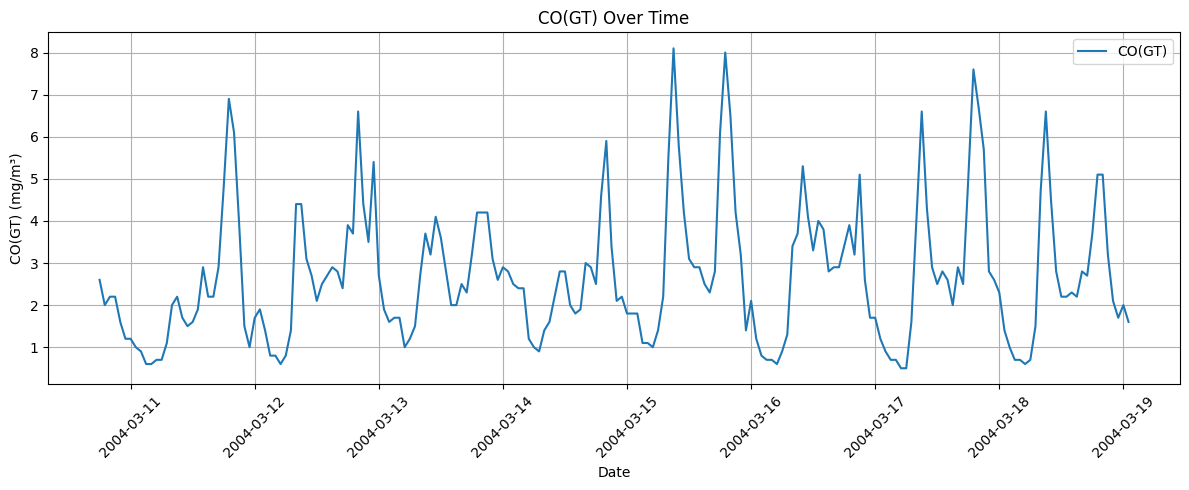

In [3]:
def plot_time_series(df, col, max_points=200, title='CO(GT) Over Time'):
    """
    Plot a time series from the DataFrame column.

    Args:
        df (pd.DataFrame): DataFrame with datetime index.
        col (str): Column to plot.
        max_points (int): Number of points to display.
        title (str): Plot title.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(df.index[:max_points], df[col][:max_points], label=col)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(f'{col} (mg/m³)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot CO(GT)
plot_time_series(df, 'CO(GT)')

## 4. Prepare Data for RNN

RNNs require input in the shape `(samples, sequence_length, features)`. We:
- Normalize features using `MinMaxScaler`
- Create sequences of 24 timesteps to predict the next hour's `CO(GT)`
- Split into training and test sets (80/20)

In [4]:
def create_sequences(data, seq_length, target_col_idx=0):
    """
    Create sequences for RNN training.

    Args:
        data (np.ndarray): Normalized data array (samples, features).
        seq_length (int): Length of input sequences.
        target_col_idx (int): Index of target column (default: 0 for CO(GT)).

    Returns:
        tuple: (X, y) where X is (samples, seq_length, features) and y is (samples, 1).
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Sequence of seq_length timesteps
        y.append(data[i + seq_length, target_col_idx])  # Next CO(GT) value
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    if X.shape[0] == 0:
        raise ValueError(f'No sequences created. Check data length ({len(data)}) and seq_length ({seq_length}).')
    return X, y

# Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df)

# Create sequences (24 hours = 24 timesteps)
seq_length = 24
X, y = create_sequences(data_normalized, seq_length)

# Split into training and test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: X={X_train.shape}, y={y_train.shape}')
print(f'Test data shape: X={X_test.shape}, y={y_test.shape}')


Training data shape: X=(7466, 24, 4), y=(7466, 1)
Test data shape: X=(1867, 24, 4), y=(1867, 1)


## 5. Build and Train the RNN Model
We use a simple RNN with one layer (50 units) followed by a Dense layer to predict `CO(GT)`. **Why simple RNN?** It’s sufficient for short sequences but may struggle with long-term dependencies due to vanishing gradients (explored in Next Steps).
**Hyperparameters**:
- Optimizer: Adam (learning rate = 0.001)
- Loss: Mean Squared Error (MSE)
- Epochs: 20
- Batch size: 32

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='tanh', input_shape=(seq_length, X_train.shape[2])),
    tf.keras.layers.Dense(1)
], name='CO_Model_RNN')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()


d:\Mandi\DL Workshop\Into-NNs-main\code\code-NNs\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "CO_Model_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0061
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 12/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

## 6. Visualize Training History

Plot training and validation loss to assess model convergence.

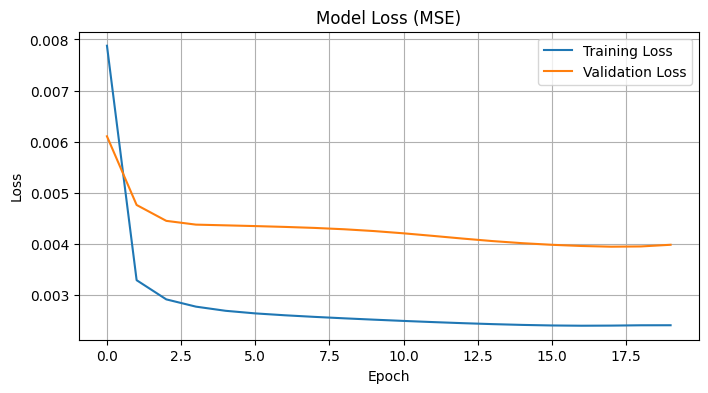

In [7]:
def plot_training_history(history):
    """
    Plot training and validation loss curves.

    Args:
        history: Keras History object from model.fit().
    """
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

## 7. Evaluate and Visualize Predictions

Predict on the test set, inverse-scale the results, and compute RMSE. Visualize true vs. predicted CO(GT) with datetime axes.

Test RMSE: 0.6035 mg/m³


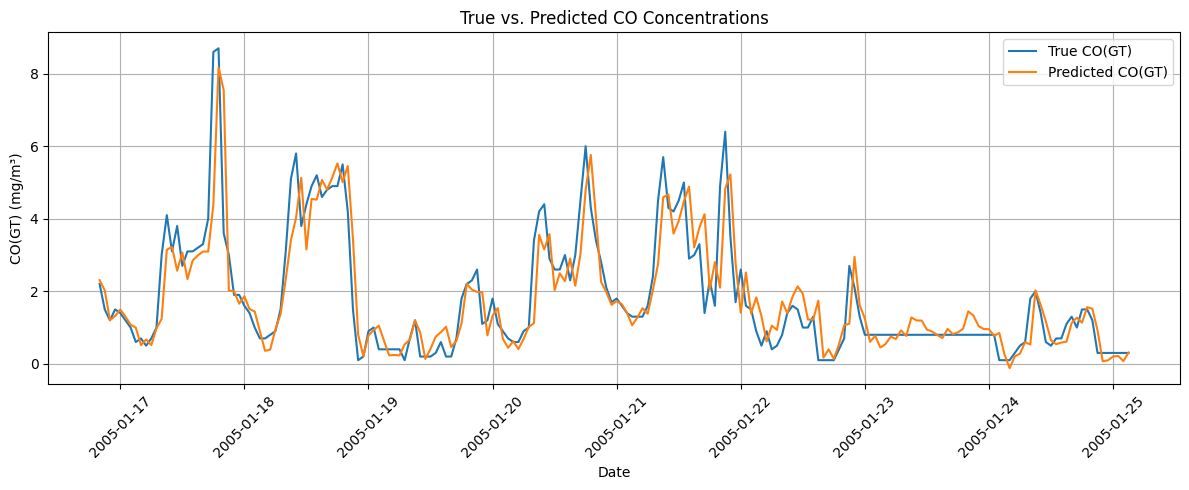

In [8]:
def evaluate_and_plot_predictions(model, X_test, y_test, scaler, dates, max_points=200):
    """
    Evaluate the model and plot true vs. predicted values.

    Args:
        model: Trained Keras model.
        X_test: Test input sequences.
        y_test: True test targets.
        scaler: Fitted MinMaxScaler for inverse transformation.
        dates: Datetime index for test set.
        max_points (int): Number of points to plot.
    """
    # Predict
    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform
    y_test_full = np.zeros((len(y_test), scaler.n_features_in_))
    y_pred_full = np.zeros((len(y_pred), scaler.n_features_in_))
    y_test_full[:, 0] = y_test.flatten()
    y_pred_full[:, 0] = y_pred.flatten()
    y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]
    y_pred_inv = scaler.inverse_transform(y_pred_full)[:, 0]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f'Test RMSE: {rmse:.4f} mg/m³')

    # Plot predictions
    plt.figure(figsize=(12, 5))
    plt.plot(dates[:max_points], y_test_inv[:max_points], label='True CO(GT)')
    plt.plot(dates[:max_points], y_pred_inv[:max_points], label='Predicted CO(GT)')
    plt.title('True vs. Predicted CO Concentrations')
    plt.xlabel('Date')
    plt.ylabel('CO(GT) (mg/m³)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluate and plot (use dates after sequence length)
test_dates = df.index[train_size + seq_length:train_size + seq_length + len(y_test)]
evaluate_and_plot_predictions(model, X_test, y_test, scaler, test_dates)

## 9. Debugging Exercise

**Task**: The following code has a bug that causes a shape mismatch during training. Identify and fix it.

```python
# Buggy code
X_train_bug = X_train.reshape(-1, seq_length)  # Incorrect shape
model.fit(X_train_bug, y_train, epochs=1)
```

**Hint**: Check the expected input shape for the RNN layer. How should `X_train` be shaped?

## 10. Summary and Next Steps

**Key Takeaways**:
- RNNs excel at modeling sequential data by maintaining a hidden state.
- Preprocessing (e.g., handling missing values, normalization) is critical for real-world datasets.
- Visualizations help interpret model performance and data patterns.

**Limitations**:
- Simple RNNs may struggle with long-term dependencies due to vanishing gradients.
- Our model uses only four features; including more sensors could improve accuracy.

**Next Steps**:
- Replace SimpleRNN with LSTM or GRU to handle longer sequences.
- Try multivariate forecasting (predict multiple pollutants).
- Experiment with attention mechanisms for better context modeling.
- Apply the model to another dataset (e.g., stock prices, weather).

**Reflection Questions**:
1. How does sequence length affect model performance and training time?
2. Why is forward fill appropriate for time series imputation?
3. What patterns in the CO(GT) plot suggest challenges for the RNN?
4. How might additional features (e.g., NOx, wind speed) improve predictions?